In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras_applications import vgg16
from keras.models import Sequential,load_model
from keras.layers import Dense,Activation,Conv2D,Flatten,MaxPooling2D,Dropout
from keras.optimizers import  Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9 # 使⽤45%記憶體
set_session(tf.Session()) 

In [3]:
def load_data(file_path):

    '''
    load all of training data
    '''

    with open(file_path, "r") as lines:
        data_list = []
        for line in lines:
            data_list.append(line.replace('\n',''))

#         shuffle(data_list) 

    data_path = []
    data_label = []
    for data in data_list:
        data_path.append(data.split(' ')[0])
        data_label.append(int(data.split(' ')[1]))

    return data_path, data_label

In [4]:
train_datareshape=[]
path_train_x=load_data('train_data.txt')[0]
for im in path_train_x:
    im=np.array(Image.open(im).resize((80,80))).reshape(80,80,1)
    train_datareshape.append(im)
train_datareshape=np.array(train_datareshape)
train_datareshape_=[]
path_train_y=load_data('train_data.txt')[1]
for y in path_train_y:    
    im_y_ = np_utils.to_categorical(y,4)
    train_datareshape_.append(im_y_)
print(len(train_datareshape_),im_y_[0])


66787 1.0


In [5]:
path_train_x=load_data('train_data.txt')[0]
print(path_train_x[1555])
raw_image = Image.open('NORMAL-1384-1.jpg')
raw_image
path_train_y=load_data('train_data.txt')[1]
print(path_train_y[1555])

../DeepLearning/kermany2018/NewSize/train/NORMAL/NORMAL-8957096-13.jpeg
3


In [5]:

x_train=train_datareshape
y_train=np.array(train_datareshape_)
print(x_train.shape)
print(y_train.shape)

(66787, 80, 80, 1)
(66787, 4)


In [6]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 30)

In [7]:
print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)


(60108, 80, 80, 1)
(6679, 80, 80, 1)
(60108, 4)
(6679, 4)


In [9]:
input_shape = (80, 80, 1)
num_classes = 4

# model = VGG16(weights='imagenet', include_top=True)

model = Sequential([
    Conv2D(256, (3, 3), input_shape=input_shape, padding='same',
           activation='relu'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same',),
    Conv2D(64, (3, 3), activation='relu', padding='same',),
    Conv2D(64, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     Conv2D(512, (3, 3), activation='relu', padding='same',),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 80, 80, 256)       2560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 80, 80, 256)       590080    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 40, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 128)       295040    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 20, 20, 64)        73792     
__________

In [10]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [12]:
epochs = 45 
batch_size = 64
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/45
939/939 [==============================] - 123s 131ms/step - loss: 0.7816 - acc: 0.6981 - val_loss: 0.5459 - val_acc: 0.8069
Epoch 2/45
939/939 [==============================] - 120s 127ms/step - loss: 0.3916 - acc: 0.8617 - val_loss: 0.3886 - val_acc: 0.8669
Epoch 3/45
939/939 [==============================] - 120s 127ms/step - loss: 0.3121 - acc: 0.8945 - val_loss: 0.4157 - val_acc: 0.8700
Epoch 4/45
939/939 [==============================] - 120s 127ms/step - loss: 0.2741 - acc: 0.9081 - val_loss: 0.4496 - val_acc: 0.8688
Epoch 5/45
939/939 [==============================] - 120s 127ms/step - loss: 0.2627 - acc: 0.9112 - val_loss: 0.3174 - val_acc: 0.9078
Epoch 6/45
939/939 [==============================] - 120s 127ms/step - loss: 0.2441 - acc: 0.9168 - val_loss: 0.2877 - val_acc: 0.9079
Epoch 7/45
939/939 [==============================] - 120s 127ms/step - loss: 0.2382 - acc: 0.9194 - val_loss: 0.2439 - val_acc: 0.9227
Epoch 8/45
939/939 [============================

In [13]:
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
model.save("model_2.h5")

6679/6679 [==============================] - 5s 744us/step
Validation: accuracy = 0.937116  ;  loss_v = 0.215389


In [14]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

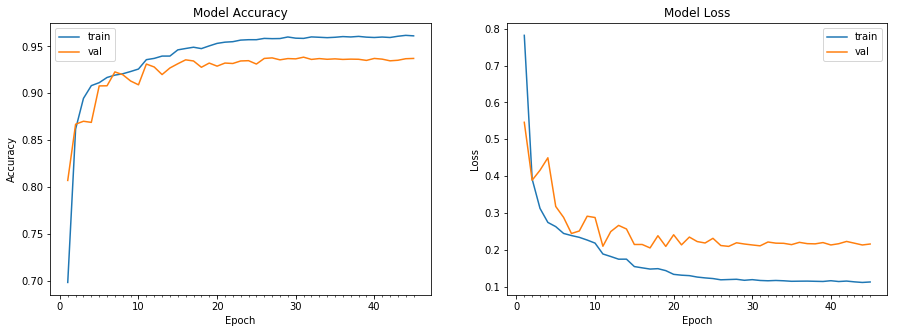

In [15]:
plot_model_history(history)

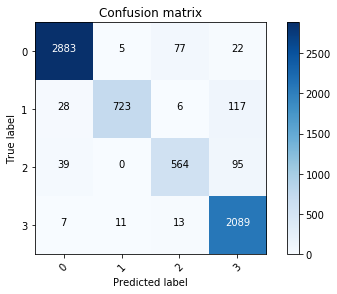

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

In [17]:
model = load_model('model_2.h5')

In [18]:
x_train.shape

(60108, 80, 80, 1)

In [20]:
loss_v, accuracy_v = model.evaluate(x_validate[:100], y_validate[:100], verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

100/100 [==============================] - 0s 3ms/step
Validation: accuracy = 0.940000  ;  loss_v = 0.168387


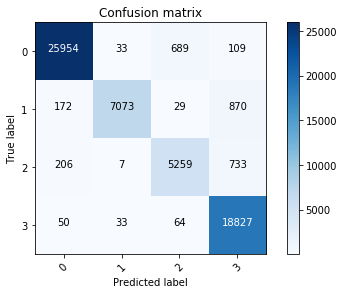

In [21]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_train)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_train,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4)) 

In [189]:
print(type(x_validate))
Y_pred = model.predict(x_validate[:10])
for i in Y_pred:
    print(np.argmax(i))
print(y_validate[:10])

<class 'numpy.ndarray'>
3
2
0
0
1
1
0
1
3
1
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [22]:
print(Image.open('kermany2018/NewSize/train/NORMAL/NORMAL-8997758-4.jpeg').size)

img = np.asarray(Image.open('kermany2018/NewSize/test/DME/DME-138971-2.jpeg').resize((80,80)))
print(img.size)
img = np.asarray(img.tolist())
# normalized_image = img/255

im = img.reshape(80,80,1)
print(im.shape)
img = np.expand_dims(im, axis=0)
print(type(img))
pred = model.predict(img)

print(np.argmax(pred))
# pred = np.array(pred[0])
# print(np.argmax(pred))



# loss_v, accuracy_v = model.evaluate(img, 1, verbose=1)
# print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))



(496, 496)
6400
(80, 80, 1)
<class 'numpy.ndarray'>
1
